# Tomato

### Import librarires

In [1]:
import os
import random

import pandas as pd
import shutil
import torch
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
import PIL
from torch import nn
from torch.utils.data import DataLoader

## Explore Data

In [2]:
data_dir = os.path.join("../data/plant disease", "Tomato")
folders = os.listdir(data_dir)
print("Tomato data classes:", len(folders))
print(*folders, sep= ", ")

Tomato data classes: 5
Tomato healthy, Tomato leaf blight, Tomato leaf curl, Tomato septoria leaf spot, Tomato verticulium wilt


Tomato healthy                468
Tomato leaf blight           1308
Tomato leaf curl              514
Tomato septoria leaf spot    2743
Tomato verticulium wilt       759
dtype: int64


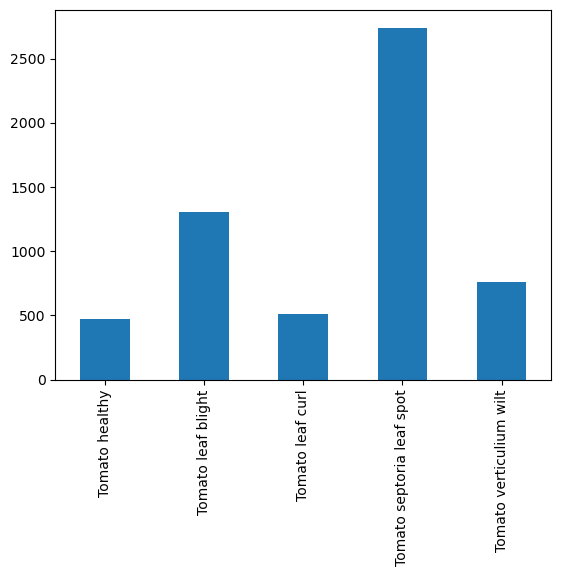

In [3]:
class_counts = []
for clss in folders:
    class_dir = os.path.join(data_dir, clss)
    class_counts.append(len(os.listdir(class_dir)))
class_dist = pd.Series(class_counts, index= folders)
print(class_dist)
class_dist.plot(kind= "bar");

Before going forward with the data, let's clear out some corrupted data.

In [4]:
count = 0

for fld in folders:
    fld_path = os.path.join(data_dir, fld)
    imgs = os.listdir(fld_path)
    for img in imgs:
        img_path = os.path.join(fld_path, img)
        try:
            image = PIL.Image.open(img_path)
            image.verify()
        except OSError:
            os.remove(img_path)
            count += 1

print(f"{count} images are corrupte and removed!")

0 images are corrupte and removed!


After the corrupted data is removed, see the data distribution among the classes.

Tomato healthy                468
Tomato leaf blight           1308
Tomato leaf curl              514
Tomato septoria leaf spot    2743
Tomato verticulium wilt       759
dtype: int64


<Axes: >

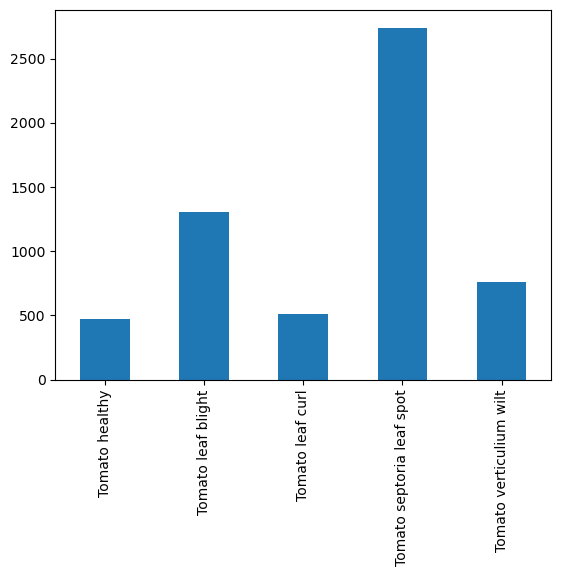

In [5]:
class_counts = []

for clss in folders:
    class_path = os.path.join(data_dir, clss)
    class_counts.append(len(os.listdir(class_path)))

class_dist = pd.Series(class_counts, index= folders)
print(class_dist)
class_dist.plot(kind= "bar")

As can be seen above, the data is not unifrmily distributed (***unbalanced***). Therefore, the data should be $undersampled$ to have a balanced distribution across classes. The undersampling process takes the minimum number of images from all the classes and prepares new data with equal size for all of the classes.

In [6]:
dest_path = os.path.join(data_dir, "undersampled")

images_class = {
    clss: os.listdir(os.path.join(data_dir, clss)) for clss in os.listdir(data_dir)
}

class_size = min(class_dist)

for clss, images in images_class.items():
    print(f"Copying images from {clss}")
    clss_dst_dir = os.path.join(dest_path, clss)

    if not os.path.exists(clss_dst_dir):
        os.makedirs(clss_dst_dir)

    samples = random.sample(images, class_size)

    for img_name in tqdm(samples, "Copying"):
        src_dir = os.path.join(data_dir, clss, img_name)
        dst_dir = os.path.join(clss_dst_dir, img_name)
        shutil.copy2(src_dir, dst_dir)
    
    print(f"Done cpying {clss} images.\n")


Copying images from Tomato healthy


Copying:   0%|          | 0/468 [00:00<?, ?it/s]

Done cpying Tomato healthy images.

Copying images from Tomato leaf blight


Copying:   0%|          | 0/468 [00:00<?, ?it/s]

Done cpying Tomato leaf blight images.

Copying images from Tomato leaf curl


Copying:   0%|          | 0/468 [00:00<?, ?it/s]

Done cpying Tomato leaf curl images.

Copying images from Tomato septoria leaf spot


Copying:   0%|          | 0/468 [00:00<?, ?it/s]

Done cpying Tomato septoria leaf spot images.

Copying images from Tomato verticulium wilt


Copying:   0%|          | 0/468 [00:00<?, ?it/s]

Done cpying Tomato verticulium wilt images.



Tomato healthy               468
Tomato leaf blight           468
Tomato leaf curl             468
Tomato septoria leaf spot    468
Tomato verticulium wilt      468
dtype: int64


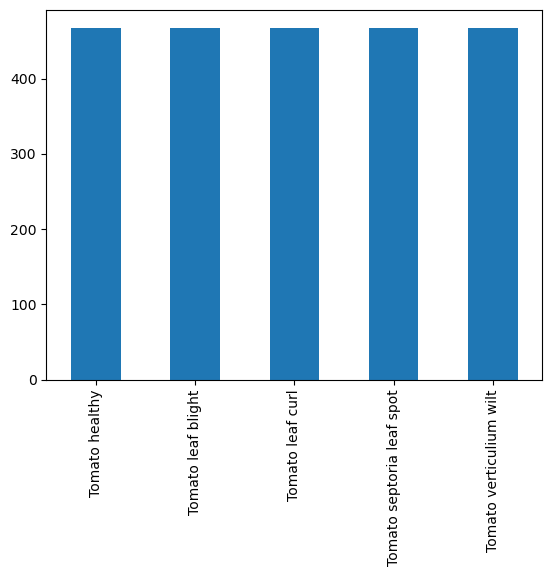

In [8]:
undersampled_data_dir = os.path.join(data_dir, "undersampled")

und_classes = os.listdir(undersampled_data_dir)

und_class_counts = []

for clss in und_classes:
    class_path = os.path.join(undersampled_data_dir, clss)
    und_class_counts.append(len(os.listdir(class_path)))

und_class_dist = pd.Series(und_class_counts, index= und_classes)
print(und_class_dist)
und_class_dist.plot(kind= "bar");

In [9]:
sum(und_class_dist)

2340

Now the data is balanced.

We need to convert our image data to tensor. The transformation pipeline takes 3 steps:
1. make the images have same mode, RGB
2. resize the images to (224, 224)
3. convert the resized images to tensors.

In [10]:
class Convt2RGB(object):
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

transformer = transforms.Compose(
    [
        Convt2RGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]
)

In [11]:
dataset = datasets.ImageFolder(undersampled_data_dir, transformer)
len(dataset)

2340

In [12]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [13]:
dataset[0][0].shape

torch.Size([3, 224, 224])

Now the image data is converted to Tensor of shape (3, 224, 224) with 3 for number of channels (RGB), the two 224 are width and height of the image after resizing the image.

The next step is to standardize the dataset.

In [14]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size= batch_size)
print(type(dataloader))
print(len(iter(dataloader)))

<class 'torch.utils.data.dataloader.DataLoader'>
74


The dataset is arranged in 46 batches. Let's check the shape of the first batch.

In [15]:
print(next(iter(dataloader))[0].shape)

torch.Size([32, 3, 224, 224])


Therefore, the first batch has 32 images, each having 3 channels (RGB), and width and height of 224 pixels.

In [16]:
means, stds = 0, 0

for data, _ in dataloader:
    means += data.mean(dim= [0, 2, 3])
    
means

OSError: broken data stream when reading image file

In [19]:
means_per_chnl, std_per_chnl, num_batches = 0, 0, 0

for data, _ in tqdm(dataloader, desc= "Calculating mean and std per channel:"):
    means_per_chnl += torch.mean(data, dim= [0, 2, 3])
    std_per_chnl += torch.mean(data ** 2, dim= [0, 2, 3])
    num_batches += 1

mean = means_per_chnl / num_batches
std = (std_per_chnl / num_batches - mean ** 2) ** 0.5
print(mean)
print(std)

Calculating mean and std per channel::   0%|          | 0/74 [00:00<?, ?it/s]

OSError: broken data stream when reading image file

In [83]:
std = dataset[0][0].std(dim= [1, 2])
std

tensor([0.1439, 0.1626, 0.1404])

In [80]:
mean

tensor([0.1439, 0.1626, 0.1404])